In this notebook we perform further modelling of the data with a LightGBM model.

# Modelling

In [1]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import lightgbm as lgb
import shap
from sklearn.preprocessing import OrdinalEncoder

pd.options.display.max_rows = None

In [2]:
ts = time.time()
data = pd.read_pickle('data.pkl')
time.time() - ts

1.3122024536132812

In [3]:
data.shape

(9803902, 188)

In [4]:
#def fill_na_lag(df):
#    for col in df.columns:
#        if ('lag' in col):            
#            df[col].fillna(0, inplace = True)               
#    return df

#data = fill_na_lag(data)

In [5]:
data.isnull().sum(axis = 0)

date_block_num                                          0
shop_id                                                 0
item_id                                                 0
category_id                                             0
item_name2                                              0
item_name3                                              0
item_name_first11                                       0
item_category_id                                        0
type_code                                               0
subtype_code                                            0
year                                                    0
day_quality                                             0
first_sale_day                                          0
prev_days_on_sale                                       0
item_age                                                0
item_name_first4_age                                    0
item_name_first6_age                                    0
item_name_firs

In [6]:
#data.fillna(0, inplace = True)

In [7]:
test = pd.read_csv('kaggle/input/competitive-data-science-predict-future-sales/test.csv')

X = data.drop('item_cnt_month_shop_item', axis = 1) # We drop the target.

X_train = X[X.date_block_num < 33]
y_train = data[data.date_block_num < 33]['item_cnt_month_shop_item']

X_val = X[X.date_block_num == 33]
y_val = data[data.date_block_num == 33]['item_cnt_month_shop_item']

X_test = X[X.date_block_num == 34]
X_test = X_test.reset_index()
del X_test['index']
del data
del X
gc.collect();

print('No. records in training data:', len(X_train))
print('No. records in validation data:', len(X_val))
print('No. records in test data:', len(X_test))

No. records in training data: 9353378
No. records in validation data: 236324
No. records in test data: 214200


We build and train a LightGBM model with optimized hyperparameters.

In [8]:
def build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features):
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val)
    model = lgb.train(params = params, train_set = lgb_train, valid_sets = (lgb_train, lgb_val), verbose_eval = 50,
                      categorical_feature = cat_features)    
    return model

In [9]:
#No HPO
#params = {
#    'objective': 'rmse',
#    'metric': 'rmse',    
#    'num_rounds': 1000,
#    'early_stopping_rounds': 30,
#    'seed': 1
#}

#Borrowed HPO
params = {
    'seed': 1,
    'objective': 'rmse',
    'metric': 'rmse',
    'num_rounds': 10000,
    #'early_stopping_rounds': 30,
    'early_stopping_rounds': 50,    
    'num_leaves': 1023,
    #'num_leaves': 2046,
    #'num_leaves': 511,
    #'num_leaves': 2000,
    #'num_leaves': 4000,
    #'num_leaves': 500,
    'min_data_in_leaf':10,
    #'min_data_in_leaf':100,
    'feature_fraction':0.7,
    'learning_rate': 0.01,  
    #'learning_rate': 0.001, 
}

#Our own HPO
#params = {
#    'objective': 'rmse',
#    'metric': 'rmse',
#    'num_rounds': 2000,
#    'early_stopping_rounds': 30,
#    'seed': 1,
#    'num_leaves': 1023,
#    'min_data_in_leaf':10,
#    'feature_fraction':0.7,
#    'learning_rate': 0.01,
#    'bagging_fraction': 0.7 # Add bagging_fraction (subsample), following JFP's advice.
#}

# Designating the categorical features which should be focused on
cat_features = ['item_category_id', 'month', 'shop_id', 'city_code']

In [10]:
ts = time.time()
#model = build_lgb_model(params, X_train, X_val, y_train, y_val)
model = build_lgb_model(params, X_train, X_val, y_train, y_val, cat_features)
time.time() - ts

Found `num_rounds` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'item_category_id', 'month', 'shop_id']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 10.497691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28630
[LightGBM] [Info] Number of data points in the train set: 9353378, number of used features: 187


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 0.300169
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.970559	valid_1's rmse: 0.97892
[100]	training's rmse: 0.83901	valid_1's rmse: 0.908601
[150]	training's rmse: 0.769218	valid_1's rmse: 0.878242
[200]	training's rmse: 0.728826	valid_1's rmse: 0.863526
[250]	training's rmse: 0.701677	valid_1's rmse: 0.85609
[300]	training's rmse: 0.681149	valid_1's rmse: 0.851155
[350]	training's rmse: 0.665016	valid_1's rmse: 0.847806
[400]	training's rmse: 0.652145	valid_1's rmse: 0.845744
[450]	training's rmse: 0.64114	valid_1's rmse: 0.843993
[500]	training's rmse: 0.631678	valid_1's rmse: 0.842535
[550]	training's rmse: 0.62368	valid_1's rmse: 0.841586
[600]	training's rmse: 0.616501	valid_1's rmse: 0.840862
[650]	training's rmse: 0.610032	valid_1's rmse: 0.840494
[700]	training's rmse: 0.604109	valid_1's rmse: 0.840132
[750]	training's rmse: 0.598512	valid_1's rmse: 0.839769
[800]	training's rmse: 0.593284	valid

2616.1890802383423

Early stopping, best iteration is:
[342]	training's rmse: 0.703315	valid_1's rmse: 0.882618

Early stopping, best iteration is:
[342]	training's rmse: 0.703315	valid_1's rmse: 0.882618 ('early_stopping_rounds': 50,)

Early stopping, best iteration is:
[375]	training's rmse: 0.655352	valid_1's rmse: 0.880583 ('num_leaves': 2000,)

Early stopping, best iteration is:
[253]	training's rmse: 0.654663	valid_1's rmse: 0.885075 'num_leaves': 4000,

Early stopping, best iteration is:
[580]	training's rmse: 0.705289	valid_1's rmse: 0.883148 num_leaves': 500,

Early stopping, best iteration is:
[300]	training's rmse: 0.720175	valid_1's rmse: 0.873057 'num_leaves': 2000, 'min_data_in_leaf':100,

Early stopping, best iteration is:
[3387]	training's rmse: 0.70413	valid_1's rmse: 0.882355

In [ ]:
filename = 'lgb_model_best.txt' 

In [ ]:
model.save_model(filename)

In [ ]:
model = lgb.Booster(model_file = 'models/lgb_model_#4.txt')

In [ ]:
model.params

In [11]:
y_test = model.predict(X_test).clip(0, 20)

my_submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
my_submission.to_csv('lgb_submission.csv', index=False)
my_submission.head()

,ID,item_cnt_month
0,0,0.683656
1,1,1.414929
2,2,1.054114
3,3,0.955902
4,4,2.214907


<Figure size 432x288 with 0 Axes>

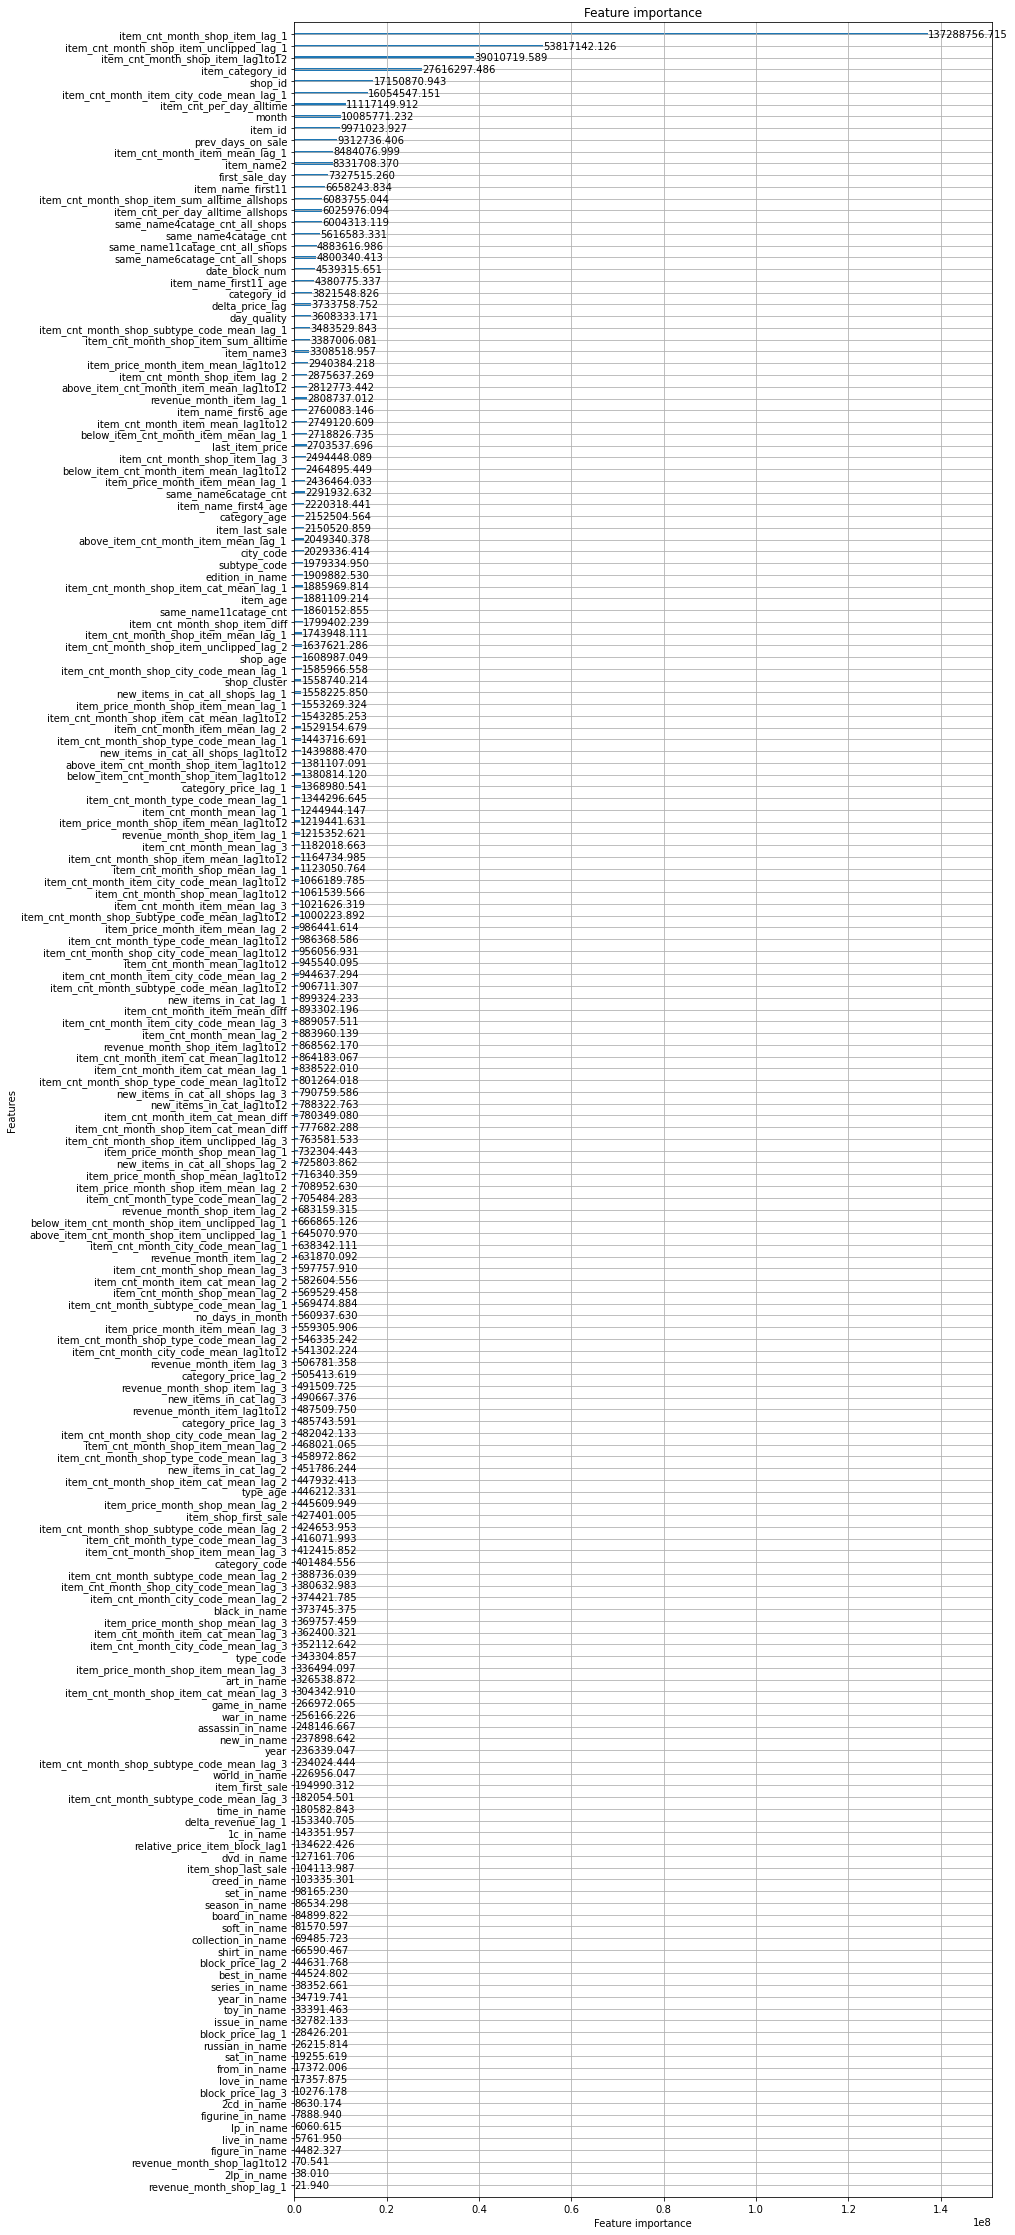

In [12]:
plt.tight_layout()
plot = lgb.plot_importance(model, figsize = (12.5, 40), importance_type = 'gain')
fig = plot.get_figure()
#fig.savefig('plots/' + filename + '.jpg')

In [13]:
print('Number of features before feature selection:', len(model.feature_importance()))
features_to_keep_lgb = []
thresh = 0
for feat_imp, feat_name in zip(model.feature_importance(), model.feature_name()):
    if feat_imp > thresh:
        features_to_keep_lgb.append(feat_name)
print('Number of features after feature selection:', len(features_to_keep_lgb))
print('Features excluded:', set(list(X_train.columns)) - set(features_to_keep_lgb))

Number of features before feature selection: 187
Number of features after feature selection: 184
Features excluded: {'revenue_month_shop_lag_3', 'audiobooks_in_name', 'revenue_month_shop_lag_2'}


# Evaluation of models

1. Score: 0.92230 (better), train. score: 0.774059, val. score: 0.889531, Coursera public/private score: 10/10 (0.928094) - Default lgb model (only num_round: 1000 and early_stopping_rounds: 30), categorical_feature not used (lgb_model_#1)

2. Score: 0.90437 (better), train. score: 0.816814, val. score: 0.890085, Coursera private score: 10/10 (0.911610) - (lgb_model_#2) - cat_features = ['item_category_id', 'month', 'shop_id', 'city_code'] (lgb_model_#2)

**Note:** This result is quite suprising (top 15% score). Both train. and val. scores are worse than for #1, but the difference between train and val. is smaller (perhaps an important measure). Since we set cat_features manually, and do not let LightGBM decide itself which features to consider as categorical, we probably get some kind of regularization. It is also worth noting that many more features are found to have 0 importance, and many more have a very low importance (<10), which probably also acts as a kind of regularization.

3. **(HPO)** Score: 0.88668 (better), train. score: 0.611059, val. score: 0.865254, Coursera private score: 10/10 (0.895413) - (lgb_model_#3) - HPO used by Luke M,

**Note:** A very good score which gives us a ranking of #598. Also, with HPO more features have a higher importance according to the feature importance plot.

4. **(HPO)** Score: 0.90610 (worse), train. score: 0.573236, val. score: 0.86665 - (lgb_model_#4) - Add item_id to cat_features.

**Note:** We get a very low train. score (even lower than what Luke M gets), but the the val. score isn't improved (huge difference now). This must be an evident example of overfitting and regularization should hopefully remedy the situation.

5. **(HPO)** Score: 0.91165, train. score: 0.598947, val. score: 0.868663 - (lgb_model_#5) - Add item_id to cat_features and use LabelEncoder() on it.

6. **(HPO)** Score: 0.90610 , train. score: 0.573236, val. score: 0.86665 - (lgb_model_#6) - Make sure item_id consists of continuous integers.

**Note:** Perhaps the HPO is not optimal for this choice of cat features.

7. Score: 0.95441 (worse, also worse than lgb_model_#2), train. score: 0.706036, val. score: 0.91014 - (lgb_model_#7) - Same as the previous model but no HPO this time.

8. Score: 0.95441, train. score: 0.706036, val. score: 0.91014 - (lgb_model_#8) - No HPO and no relabelling of item_id.

**Note:** The relabelling doesn't change anything.

**Response from Luke M:** According to the documentation of LightGBM (https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html), it is not a good idea to set a feature with high cardinality as categorical, it's better to treat it as numerical.

9. Score: -, train. score: 0.816814, val. score: 0.890085 - (lgb_model_#9) - We do not set item_id as categorical, we relabel categorial features that have discontinuities (item_category_id and shop_id).

**Note:** We get exactly the same train and val score as before so not worth bothering.

10. Score: 0.92060 (worse), train. score: 0.767382, val. score: 0.881765- (lgb_model_#10) - Add features with low caridnality (<100) as categorical features (no HPO).

**Note:** This is not a very smart way of adding categorical features (it makes no sense to have date_block_num as a categorical feature).

11. Score: 0.89822 (worse, but better than lgb_model_#2), train. score: 0.77139, val. score: 0.878494 - (lgb_model_#11) - Add certain features with low cardinality (<100) as categorical features (no HPO).

**Note:** It is probably a good idea to keep these categorical features, and try HPO on them.

12. **(HPO)** Score: 0.88808 (worse), train. score: 0.628101, val. score: 0.866039 - (lgb_model_#12) - Add  certain features with low caridnality (<100) as categorical features (with HPO).
	 
**Note:** This submission gets a worse score than our best submission so far, but the current selection of cat_features is probably adapted to the current HPO, so it's probably a good idea to redo the HPO for this new selection.

13. **(HPO)** Score: 0.92048 (worse) - We select lgb_model_#3 and retrain it on all data, setting train and val data as train data (lgb_model_#13_retrain).

**Note:** This did not improve the score, and questionable if it really works, especially as we're not really using CV when we train the model.

14. **(HPO)** Score: (worse), train. score: , val. score:  - (lgb_model_#14) - Add  certain features with low caridnality (<100) as categorical features (with HPO) and set bagging_fraction = 0.7 (subsample).

**Note:** Adding baggin_fraction = 0.7 did not change anything.